<a href="https://colab.research.google.com/github/revatishelat/DST_A2/blob/main/Ethan/BERT_take_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [4]:
import numpy as np
import sklearn
import pandas as pd
import nltk
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing code

In [5]:
def preprocess4(doc):
  #lowercases document
  doc = doc.lower()
  #removes any non-letter characters
  #tokenize
  toks = nltk.word_tokenize(doc)
  #remove tokens of lenth <= n (can be varied)
  toks = [tok for tok in toks if len(tok) > 4]
  #remove tokens that dont exclusively contain letters
  toks = [tok for tok in toks if re.match('^[a-zA-Z]+$', tok)]
  #remove stopwords
  toks = [tok for tok in toks if tok not in en_stop]
  #lemmatize
  toks = [WordNetLemmatizer().lemmatize(tok) for tok in toks]
  return toks

# Load data

In [6]:
url = 'https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_train.csv'
df_train = pd.read_csv(url)

In [7]:
url = 'https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_test.csv'
df_test = pd.read_csv(url)

In [8]:
df_train.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [9]:
df_test.head()

,condition_label,medical_abstract
0,3,Obstructive sleep apnea following topical orop...
1,5,Neutrophil function and pyogenic infections in...
2,5,A phase II study of combined methotrexate and ...
3,1,Flow cytometric DNA analysis of parathyroid tu...
4,4,Paraneoplastic vasculitic neuropathy: a treata...


# Embedding with DistilBERT

In [22]:
import transformers as ppb
import torch

In [11]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

This function truncates documents, as too large for DistilBERT

In [12]:
def truncate_to_n_words(input_string, n):
    words = input_string.split()[:n]
    truncated_string = ' '.join(words)
    return truncated_string

In [14]:
X_train_truncated = df_train['medical_abstract'].apply(lambda x: truncate_to_n_words(x, 100))

In [15]:
tokenized = X_train_truncated.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [16]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [17]:
np.array(padded).shape

(11550, 282)

In [18]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(11550, 282)

Function to get embedding using BERT model

In [19]:
def embed_with_BERT(padded, attention_mask):

  input_ids = torch.tensor(padded)
  attention_mask_tensor = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask_tensor)

  return last_hidden_states[0][:,0,:].numpy()

In [23]:
i=0
step=350
features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])

In [50]:
np.save('/content/drive/MyDrive/University/Bristol/Year 4/features_temp.npy', features_temp)

In [53]:
loaded_embeddings = np.load('/content/drive/MyDrive/University/Bristol/Year 4/features_temp.npy')

In [55]:
loaded_embeddings == features_temp

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [51]:
from sklearn.decomposition import PCA

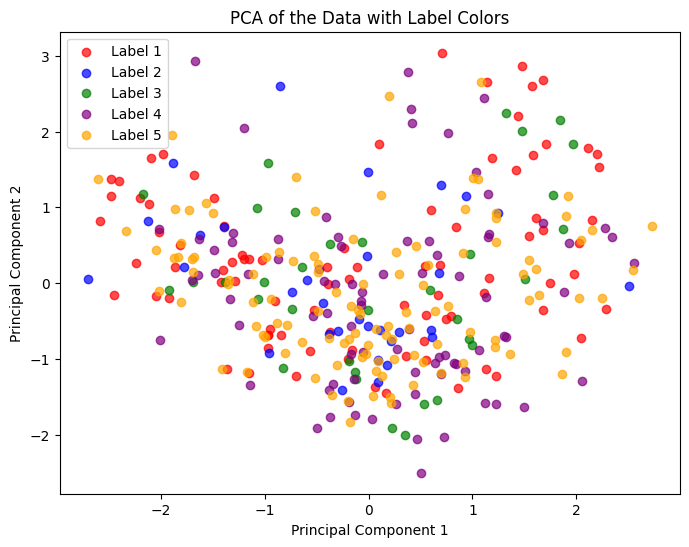

In [52]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_temp)

labels = df_train['condition_label'][:350]

label_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange'}

plt.figure(figsize=(8, 6))

for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=f'Label {label}', color=label_colors[label], alpha=0.7)

plt.title('PCA of the Data with Label Colors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

The PCA of the embeddings looks like a real mess - not promising for classification.

In [56]:
step = 350

for i in range(350, 11550, step):
  print(f'Embedding for rows {i} to {i+step}')
  features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])
  if i == 0:
    features = features_temp
  else:
    features = np.vstack((features, features_temp))
  np.save('/content/drive/MyDrive/University/Bristol/Year 4/features.npy', features)

Embedding for rows 350 to 700
Embedding for rows 700 to 1050
Embedding for rows 1050 to 1400
Embedding for rows 1400 to 1750
Embedding for rows 1750 to 2100
Embedding for rows 2100 to 2450
Embedding for rows 2450 to 2800
Embedding for rows 2800 to 3150
Embedding for rows 3150 to 3500
Embedding for rows 3500 to 3850
Embedding for rows 3850 to 4200
Embedding for rows 4200 to 4550
Embedding for rows 4550 to 4900
Embedding for rows 4900 to 5250
Embedding for rows 5250 to 5600
Embedding for rows 5600 to 5950
Embedding for rows 5950 to 6300
Embedding for rows 6300 to 6650
Embedding for rows 6650 to 7000
Embedding for rows 7000 to 7350
Embedding for rows 7350 to 7700
Embedding for rows 7700 to 8050
Embedding for rows 8050 to 8400
Embedding for rows 8400 to 8750
Embedding for rows 8750 to 9100
Embedding for rows 9100 to 9450
Embedding for rows 9450 to 9800
Embedding for rows 9800 to 10150
Embedding for rows 10150 to 10500
Embedding for rows 10500 to 10850
Embedding for rows 10850 to 11200
Embe

In [57]:
X_test_truncated = df_test['medical_abstract'].apply(lambda x: truncate_to_n_words(x, 100))

tokenized = X_train_truncated.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
step = 350

for i in range(0, 11550, step):
  print(f'Embedding for rows {i} to {i+step}')
  features_temp = embed_with_BERT(padded[i:i+step], attention_mask[i:i+step])
  if i == 0:
    features = features_temp
  else:
    features = np.vstack((features, features_temp))
  np.save('/content/drive/MyDrive/University/Bristol/Year 4/features_TEST.npy', features)

Embedding for rows 0 to 350
Embedding for rows 350 to 700


# Embedding with MobileBERT (even smaller)

https://huggingface.co/docs/transformers/model_doc/mobilebert#transformers.models.mobilebert.modeling_mobilebert.MobileBertForPreTrainingOutput

https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D

https://huggingface.co/prajjwal1/bert-tiny

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [41]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.MobileBertModel, ppb.MobileBertTokenizerFast, 'vshampor/mobilebert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

OSError: ignored

In [39]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load TinyBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("voidful/tinybert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("voidful/tinybert-base-cased")

OSError: ignored